In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
import shutil
from tensorflow import keras


In [2]:
data = pd.read_csv("river_data.csv")

data['SensorTime']= pd.to_datetime(data['SensorTime'])
data.head()


,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df = data.drop(data[data[" Stage"] <= 0].index)
print(min(df[" Stage"]))
print(max(df[" Stage"]))

1.37
6.49


In [4]:
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
validation = pd.read_csv("./data/validation_data.csv")

Found 25235 validated image filenames.
Found 12618 validated image filenames.
Found 4206 validated image filenames.
3.19
512


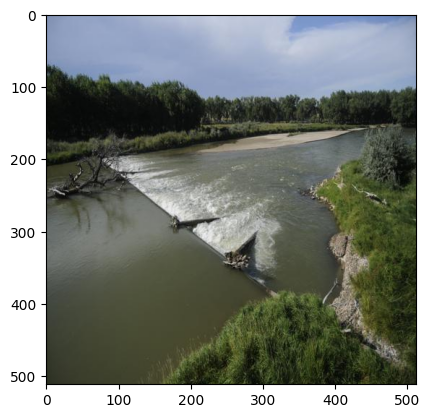

In [5]:
labels_train = train[[" Filename", " Stage"]]
labels_test = test[[" Filename", " Stage"]]
labels_validation = validation[[" Filename", " Stage"]]
generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_generator=generator.flow_from_dataframe(
    dataframe=labels_train,
    directory="./data/images/train",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

test_generator = generator.flow_from_dataframe(
    dataframe=labels_test,
    directory="./data/images/test",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

validation_generator = generator.flow_from_dataframe(
    dataframe=labels_validation,
    directory="./data/images/validation",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

plt.imshow(validation_generator[0][0][0])
print(validation_generator[0][1][0])
print(len(validation_generator[0][0][0]))


In [6]:
inputs = keras.Input(shape=(512, 512, 3))
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-01 16:02:29.045040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 16:02:29.045161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=['mse', 'mae']
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


2022-12-01 16:02:29.355029: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-01 16:02:29.582323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


789/789 [==============================] - ETA: 0s - loss: 0.5388 - mse: 0.5388 - mae: 0.4745

2022-12-01 16:04:48.172548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


789/789 [==============================] - 153s 193ms/step - loss: 0.5388 - mse: 0.5388 - mae: 0.4745 - val_loss: 0.3508 - val_mse: 0.3508 - val_mae: 0.3441
Epoch 2/10
789/789 [==============================] - 154s 195ms/step - loss: 0.3515 - mse: 0.3515 - mae: 0.3722 - val_loss: 0.3939 - val_mse: 0.3939 - val_mae: 0.4683
Epoch 3/10
789/789 [==============================] - 151s 192ms/step - loss: 0.3062 - mse: 0.3062 - mae: 0.3472 - val_loss: 0.3823 - val_mse: 0.3823 - val_mae: 0.3869
Epoch 4/10
789/789 [==============================] - 152s 192ms/step - loss: 0.2720 - mse: 0.2720 - mae: 0.3320 - val_loss: 0.2482 - val_mse: 0.2482 - val_mae: 0.2930
Epoch 5/10
789/789 [==============================] - 151s 192ms/step - loss: 0.2147 - mse: 0.2147 - mae: 0.2988 - val_loss: 0.2356 - val_mse: 0.2356 - val_mae: 0.3059
Epoch 6/10
789/789 [==============================] - 152s 192ms/step - loss: 0.1771 - mse: 0.1771 - mae: 0.2737 - val_loss: 0.1729 - val_mse: 0.1729 - val_mae: 0.2673
Epo

In [8]:
mse = model.evaluate(test_generator, verbose=0)
print("Test RMSE: ",mse)

Test RMSE:  [0.10269280523061752, 0.10269280523061752, 0.2117624282836914]


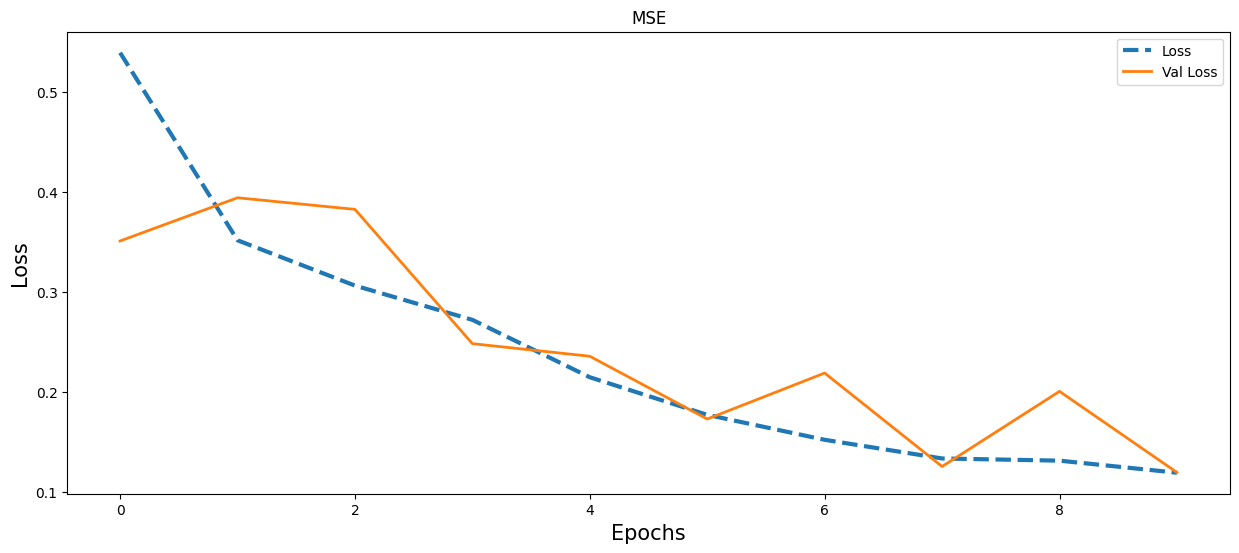

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], lw =3, ls = '--', label = 'Loss')
plt.plot(history.history['val_loss'], lw =2, ls = '-', label = 'Val Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('MSE')
plt.legend()